### Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

from collections import Counter

import nltk
from nltk import tokenize
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('words')

from sklearn import decomposition
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xuehao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\xuehao\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\xuehao\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


### Load 20newsgruops dataset (Bridget)

In [3]:
docs_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers','quotes'))
docs_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers','quotes'))

df_train = pd.DataFrame(docs_train.data, columns=['text'])
df_train['topic'] = pd.Series(data=docs_train.target, index=df_train.index)

df_test = pd.DataFrame(docs_test.data, columns=['text'])
df_test['topic'] = pd.Series(data=docs_test.target, index=df_test.index)

print(df_train.info())
print()

print(df_test.info())
print()

NUM_OF_TOPIC = len(docs_train.target_names)
print(NUM_OF_TOPIC)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11314 non-null  object
 1   topic   11314 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 132.7+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7532 entries, 0 to 7531
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7532 non-null   object
 1   topic   7532 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 88.4+ KB
None

20


### task a. Do the pre-processing. This step is application dependent and so you want to read till the end of the task description before deciding what pre-processing steps you’ll choose to apply

## pre-processing (Bridget) (Others also contributed)

In [4]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords_extension = ['dont','im','also','it','thank','thanks','could','get','would','even','know','say','much','well']
stopwords.extend(stopwords_extension)

lemmatizer = WordNetLemmatizer()

english_words = set(nltk.corpus.words.words())

START_OF_LINE = "^"
OPTIONAL = "?"
ANYTHING = "."
ZERO_OR_MORE = "*"
ONE_OR_MORE = "+"
SPACE = "\s"
SPACES = SPACE + ONE_OR_MORE
NOT_SPACE = "[^\s]" + ONE_OR_MORE
NEWLINES = "[\r\n]"
FORWARD_SLASH = "\/"
ERASE = " "

PUNCTUATION = '[^\w\s]' #^=not, \w=alphanumeric character, \s=space
EMAIL = '\w+(\.\w+)*@\w*(\.\w+)*'
HYPERLINKS = ("http" + "s" + OPTIONAL + ":" + FORWARD_SLASH + FORWARD_SLASH + NOT_SPACE + NEWLINES + ZERO_OR_MORE)

# a few header formats that has not been removed
HEADER1 = 'from ' + EMAIL
HEADER2 = 'by ' + EMAIL
HEADER3 = 'from:'
HEADER4 = 'received:'

# newline prompt
PROMPT = '[^\r\n]'+'\w+'+SPACE+OPTIONAL+PUNCTUATION+OPTIONAL+'>'

def process_text(docs_df):
    
    # process step 1:
    # convert all the letter into lower case
    # remove a few types of headers and header words
    # remove emails
    # remove newline prompt
    # remove urls
    # replace new line character with space
    # remove decimal points
    # remove numbers
    # remove punctuations other than period, question mark and exclamaition mark
    # replace underscores with space
    # remove non-english words
    
    docs_df['process_step_1'] = docs_df['text'].str.lower()
    # remove a few types of headers and header words
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub(HEADER1, ERASE, x))
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub(HEADER2, ERASE, x))
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub(HEADER3, ERASE, x))
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub(HEADER4, ERASE, x))
    # remove emails
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub(EMAIL, ERASE, x))
    # remove newline prompt
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub(PROMPT, ERASE, x))
    # remove urls
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub(HYPERLINKS, ERASE, x))
    
    # remove decimals and numbers
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub('\d\.\d', ' ', x))
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub('[\d]', ERASE, x))
    
    # remove new line characters and underscores
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub('\n', ' ', x))
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub('_*', '', x))
    
    # remove non-end-of-sentence punctuations
    # anything that is not a whitespace, not alphanumeric character, not a period, not an exclamaition mark, not a question mark
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub('[^\w\s\.\?\!]','',x))
    
    # separate punctuations from words
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub('\.+', ' . ', x))
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub('\?+', ' ? ', x))
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: re.sub('\!+', ' ! ', x))
    
    # lemmatize
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: ' '.join([lemmatizer.lemmatize(item.strip(), 'v') for item in x.split()]))
    
    # remove non english words                                                            
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: ' '.join([item for item in x.split() if (item.strip() in english_words) or (item.strip() in ('.', '?', '!'))]))
    
    # remove single letter
    docs_df['process_step_1'] = docs_df['process_step_1'].apply(lambda x: ' '.join([item for item in x.split() if item.strip() not in set("abcdefghijklmnopqrstuvwxyz")]))
        
    # step 2
    # remove stop words

    
    docs_df['process_step_2'] = docs_df['process_step_1'].apply(lambda x: ' '.join([item for item in x.split() if item.strip() not in stopwords]))
    
    # step 3
    # remove punctuations
    docs_df['process_step_3'] = docs_df['process_step_2'].apply(lambda x: re.sub(PUNCTUATION, '', x))



In [5]:
process_text(df_train)
df_train.head(5)

text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                               A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.   
2  well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i'd heard the 185c was supposed to make an\nappearence "this summer" but haven't heard anymore on it - and since i\ndon't have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo's just went through recently?\n\n* what's the impression of the display on the 180?  i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don't really have\na feel for how much "better" the display is (yea, it looks great in the\nstore, but is that all "...   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       \nDo you have Weitek's address/phone number?  I'd like to get some inf

In [6]:
process_text(df_test)
df_test.head(5)

text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        I am a little confused on all of the models of the 88-89 bonnevilles.\nI have heard of the LE SE LSE SSE SSEI. Could someone tell me the\ndifferences are far as features or performance. I am also curious to\nknow what the book value is for prefereably the 89 model. And how much\nless than book value can you usually get them for. In other words how\nmuch are they in demand this time of year. I have heard that the mid-spring\nearly summer is the best time to buy.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                 I'm not familiar at all with the format of these "X-Face:" thingies, but\nafter seeing them in some folks' headers, I've *got* to *see* them (and\nmaybe make one of my own)!\n\nI've got "dpg-view" on my Linux box (which displays "uncompressed X-Faces")\nand I've managed to compile [un]compface too... but now that I'm *looking*\nfor them, I can't seem to find any X-Face:'s in anyones news headers!  :-(\n\nCould you, would you, please send me your "X-Face:" header?\n\nI *know* I'll probably get a little swamped, but I can handle it.\n\n\t...I hope.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      \nIn a word, yes.\n   
3  \nThey were attacking the Iraqis to drive them out of Kuwait,\na country whose citizens have close blood and business ties\nto Saudi citizens.  And me thinks if the US had not helped out\nthe Iraqis would have swallowed Saudi Arabia, too (or at \nleast the eastern oilfields).  And no Muslim country was doing\nmuch of anything to help liberate Kuwait and protect Saudi\nArabia; indeed, in some masses of citizens were demonstrating\nin favor of that butcher Saddam (who killed lotsa Muslims),\njust because he was killing, raping, and looting relatively\nrich Muslims and also thumbing his nose at the West.\n\nSo how would have *you* defended Saudi Arabia and rolled\nback the Iraqi invasion, were you in charge of Saudi Arabia???\n\n\nI think that it is a very good idea to not have governments have an\nofficial religion (de facto or de jure), because with human nature\nlike it is, the ambitious and not the pious will always be the\nones who rise to power.  There a

### task b. Create plots, using matplotlib, to show the following (for each topic in the data separately and save the plots to file):

### i. Most frequent words, bigrams and trigrams

### Most Frequent Words by Topic (Faruk)

In [7]:
# Top N Most Frequent Words
TOP_N = 10
most_common_filtered_words = []

for i in range(NUM_OF_TOPIC):
    # join all the documents in one topic as a big joind_string
    joined_string = ' '.join(df_train[df_train['topic']==i]['process_step_3'])
    
    # split joined_string by white spaces, convert it into a list of words
    # convert the list of words into pd.Series
    # use value_count get TOP_N most frequent words as pd.Series
    # reset index and convert the pd.Series into a DataFrame
    df_valueCounts = pd.Series(joined_string.split()).value_counts()[:TOP_N].rename_axis('word').reset_index(name='count')
    
    most_common_filtered_words.append(df_valueCounts)
    

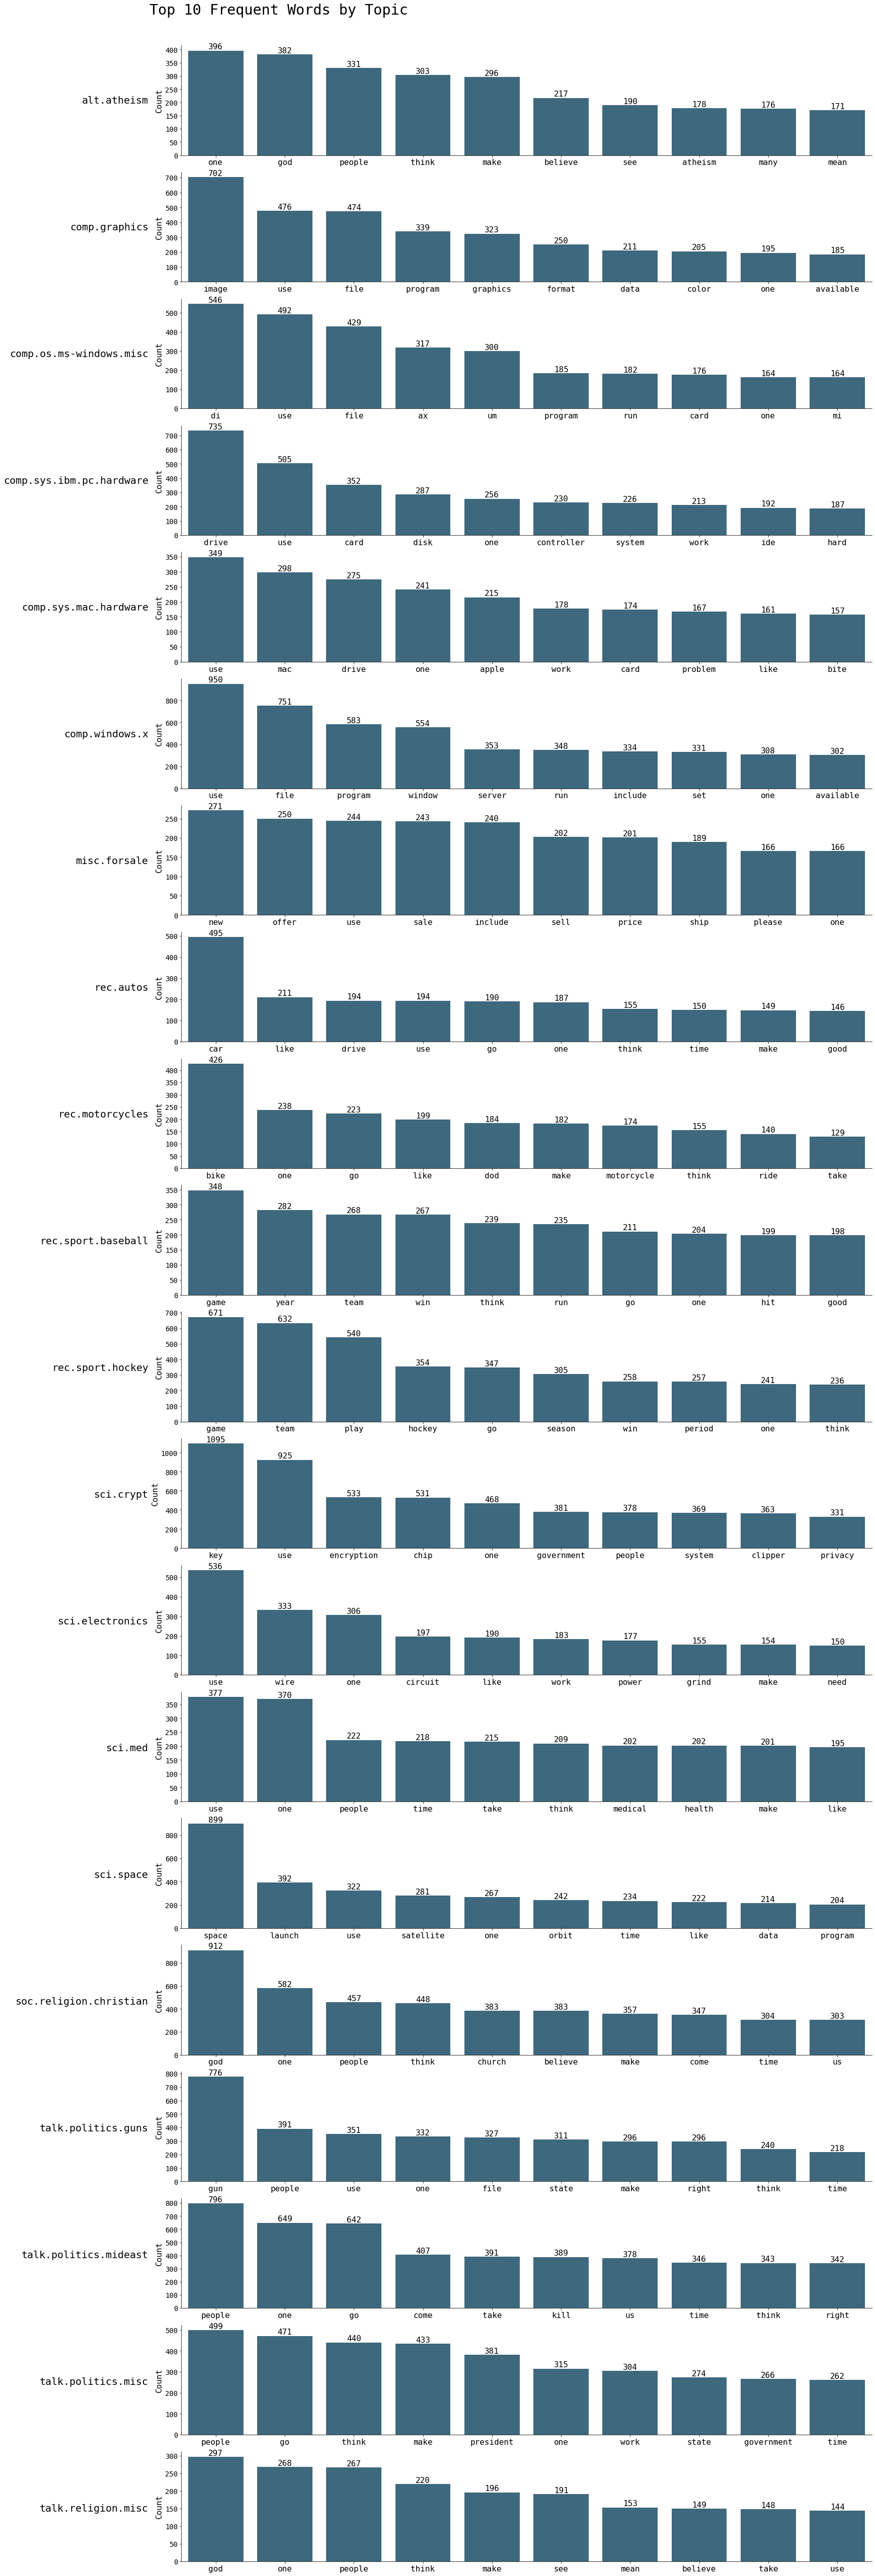

In [8]:
fig = plt.figure(figsize = (20,70))

for i in range(NUM_OF_TOPIC):
    plt.subplot(NUM_OF_TOPIC,1,i+1)
    ax = sns.barplot(data = most_common_filtered_words[i], x = 'word', y = 'count', color = '#336b87')
    ax.bar_label(ax.containers[0], fontname = 'monospace', fontsize = 16)
    plt.ylabel('Count', fontname = 'monospace', size = 16)
    plt.xlabel('')
    plt.xticks(fontname = 'monospace', size = 16, color = 'black', rotation=0, horizontalalignment='center')
    plt.yticks(fontname = 'monospace', size = 14)
    for j in ['right', 'top']:
        ax.spines[j].set_visible(False)

# Figure Text
plt.figtext(0., 1.01, 'Top 10 Frequent Words by Topic', fontname = 'monospace', size = 28.5, color = 'black')        

for i in range(NUM_OF_TOPIC):
    plt.figtext(-0.001, 0.975-0.05*i, docs_train.target_names[i], fontname = 'monospace', size = 20, ha='right')

fig.tight_layout(pad = 0.4)    

plt.savefig('Top 10 Frequent Words by Topic.png', bbox_inches='tight')        
plt.show()

### Top 10 Bigrams for Each Topic (XiaoChen)

In [9]:
# Separate documents into different lists based on their topic
topic_list = []
for i in range(NUM_OF_TOPIC):
    topic_list.append([])

# add the documents to the list based on the topic number
for index, row in df_train.iterrows():
    topic_list[row['topic']].append(row['process_step_2'])

In [10]:
# Represents the end of sentence: period, exclamation mark or question mark
END_OF_SENTENCE = '[\.\?\!]' 

# create sentence list for each topic
# sentence_list_by_topic is a list of DataFrame
sentence_list_by_topic = []
# for all the documents in the same topic
for documents in topic_list:
    sentence_list = []
    for document in documents:
        sentence = ''
        # for each character in the document
        for c in document:
            if c not in END_OF_SENTENCE:
                # if the charcter is not an END_OF_SENTENCE character
                # add the character to the sentence
                sentence += c
            else:
                # if the character is an END_OF_SENTENCE
                # strip the sentence with leading and trailing white spaces
                # if sentence length is > 0 after the strip
                # add the sentence to the sentence_list and clear the sentence string and restart
                sentence = sentence.strip()
                if len(sentence) > 0:
                    sentence_list.append(sentence)
                sentence = ''
        # at the end of the document
        # if the length of sentence > 0 after the strip, add it to the sentence_list        
        sentence = sentence.strip()
        if len(sentence) > 0:
            
            sentence_list.append(sentence)
    sentence_list_by_topic.append(pd.DataFrame(sentence_list, columns=['Sentence']))
    

In [11]:
# Top N Most Frequent Bigrams
TOP_N = 10
most_common_bigrams = []

for df_sentence in sentence_list_by_topic:
    # Getting the Bigrams
    bigrams = [b for s in df_sentence['Sentence'] for b in zip(s.split(' ')[:-1], s.split(' ')[1:])]
    most_common_bigrams.append(pd.DataFrame(Counter(bigrams).most_common(TOP_N), columns=['Bigram', 'Count']))

# most_common_bigrams[1]

In [12]:
# Bigram column: convert tuple into string
for each in most_common_bigrams: 
    each['Bigram'] = each['Bigram'].apply(lambda x: x[0] + ', ' + x[1])

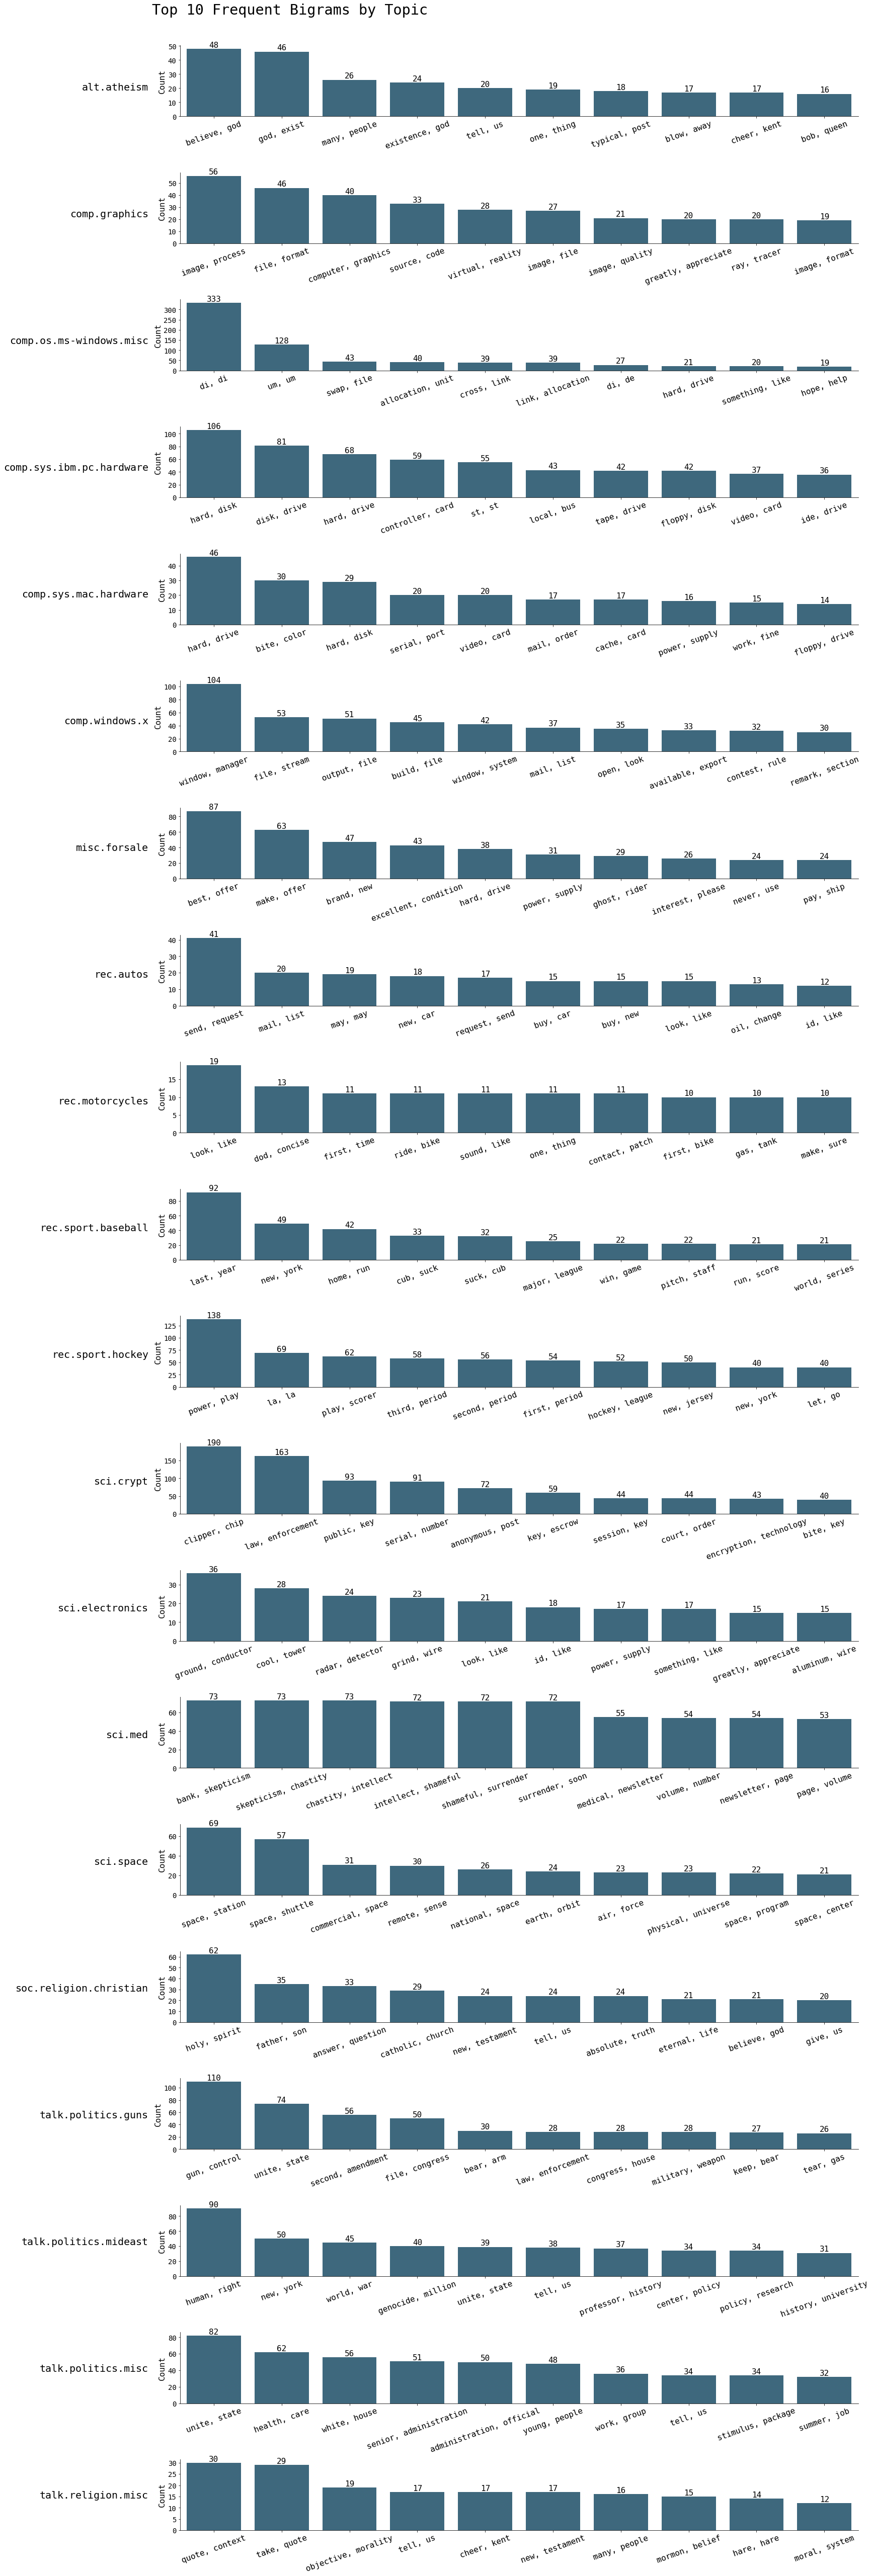

In [13]:
fig = plt.figure(figsize = (20,70))

for i in range(NUM_OF_TOPIC):
    plt.subplot(NUM_OF_TOPIC,1,i+1)
    ax = sns.barplot(data = most_common_bigrams[i], x = 'Bigram', y = 'Count', color = '#336b87')
    ax.bar_label(ax.containers[0], fontname = 'monospace', fontsize = 16)
    plt.ylabel('Count', fontname = 'monospace', size = 16)
    plt.xlabel('')
    plt.xticks(fontname = 'monospace', size = 16, color = 'black', rotation=20, horizontalalignment='center')
    plt.yticks(fontname = 'monospace', size = 14)
    for j in ['right', 'top']:
        ax.spines[j].set_visible(False)

# Figure Text
plt.figtext(0., 1.01, 'Top 10 Frequent Bigrams by Topic', fontname = 'monospace', size = 28.5, color = 'black')        

for i in range(NUM_OF_TOPIC):
    plt.figtext(-0.005, 0.98-0.05*i, docs_train.target_names[i], fontname = 'monospace', size = 20, ha='right')

fig.tight_layout(pad = 0.4)    

plt.savefig('Top 10 Frequent Bigrams by Topic.png', bbox_inches='tight')        
plt.show()


### Top 5 Trigrams for Each Topic (XiaoChen)

In [14]:
N = 5
most_common_trigrams = []

for df_sentence in sentence_list_by_topic:
    # Getting the Trigrams
    trigrams = []
    for sentence in df_sentence['Sentence']:
        words = sentence.split()
        # sentence has to have at least three words
        if len(words) >= 3:
            for i in range(len(words)-2):
                trigram = (words[i], words[i+1], words[i+2])
                trigrams.append(trigram)
    most_common_trigrams.append(pd.DataFrame(Counter(trigrams).most_common(N), columns=['Trigram', 'Count']))


In [15]:
# Convert tuple on column 'Trigram' into string
for each in most_common_trigrams: 
    each['Trigram'] = each['Trigram'].apply(lambda x: x[0] + ', ' + x[1] + ', '+ x[2])

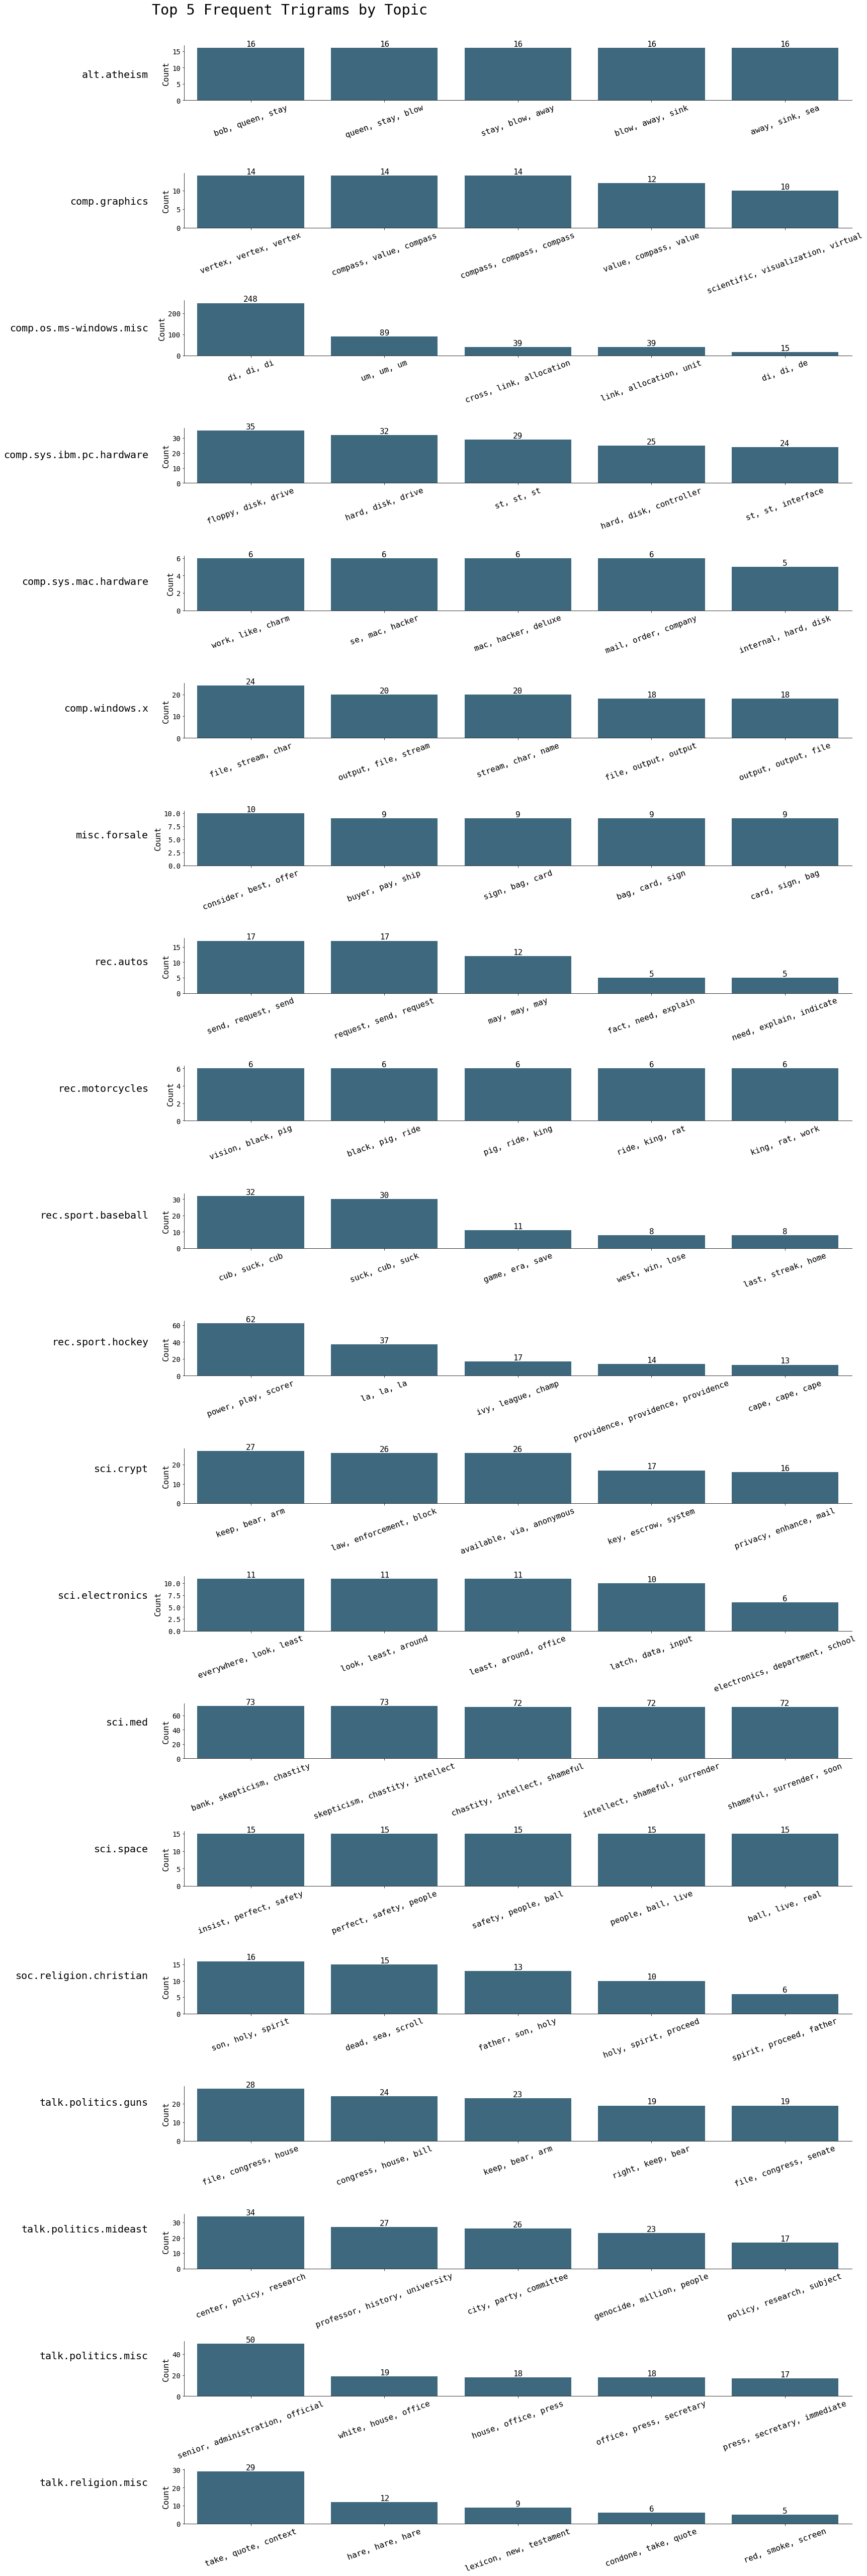

In [16]:
fig = plt.figure(figsize = (20,70))

for i in range(NUM_OF_TOPIC):
    plt.subplot(NUM_OF_TOPIC,1,i+1)
    ax = sns.barplot(data = most_common_trigrams[i], x = 'Trigram', y = 'Count', color = '#336b87')
    ax.bar_label(ax.containers[0], fontname = 'monospace', fontsize = 16)
    plt.ylabel('Count', fontname = 'monospace', size = 16)
    plt.xlabel('')
    plt.xticks(fontname = 'monospace', size = 16, color = 'black', rotation=20, horizontalalignment='center')
    plt.yticks(fontname = 'monospace', size = 14)
    for j in ['right', 'top']:
        ax.spines[j].set_visible(False)

# Figure Text
plt.figtext(0., 1.01, 'Top 5 Frequent Trigrams by Topic', fontname = 'monospace', size = 28.5, color = 'black')        

for i in range(NUM_OF_TOPIC):
    plt.figtext(-0.005, 0.985-0.05*i, docs_train.target_names[i], fontname = 'monospace', size = 20, ha='right')

fig.tight_layout(pad = 0.4)    

plt.savefig('Top 5 Frequent Trigrams by Topic.png', bbox_inches='tight')        
plt.show()

### ii. Word cloud plots

### Word Cloud (Faruk)

In [17]:
# list of TF-IDF DataFrames for each topic
tfidf_list = []
for i in range(NUM_OF_TOPIC):
    v = TfidfVectorizer()
    x = v.fit_transform(df_train[df_train['topic']==i]['process_step_3'])
    # convert the TF-IDF matrix into DataFrame
    # rename the column index
    tfidf_list.append(pd.DataFrame(x.todense(), columns = v.get_feature_names_out()))

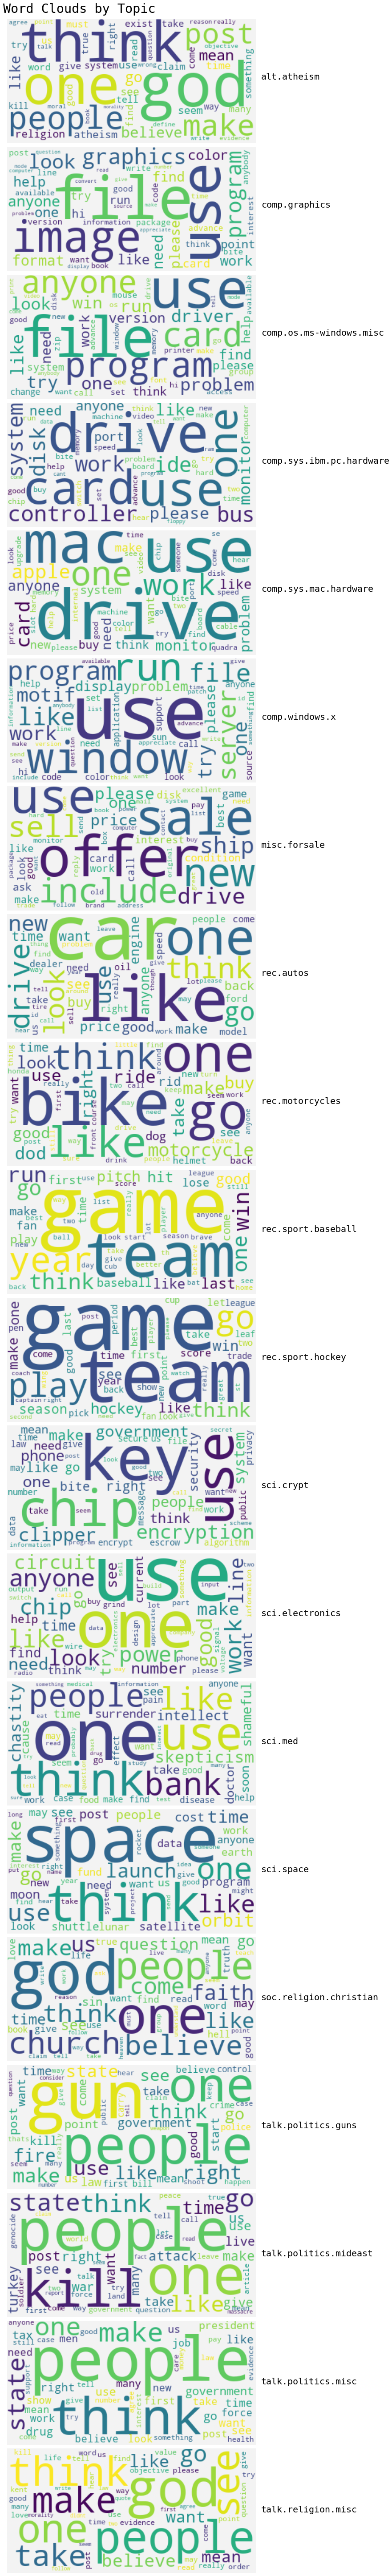

In [18]:
fig = plt.figure(figsize = (8,80))

for i in range(NUM_OF_TOPIC):
    plt.subplot(NUM_OF_TOPIC,1,i+1)
    Cloud = WordCloud(background_color="#F3F3F3", max_words=50).generate_from_frequencies(tfidf_list[i].T.sum(axis=1))
    plt.imshow(Cloud, interpolation='bilinear')
    plt.axis('off')
    

# Figure Text
plt.figtext(0., 1.001, 'Word Clouds by Topic', fontname = 'monospace', size = 28.5, color = 'black')        

for i in range(NUM_OF_TOPIC):
    plt.figtext(1.006, 0.975-0.05*i, docs_train.target_names[i], fontname = 'monospace', size = 20, ha='left')

fig.tight_layout(pad = 0.8)    

plt.savefig('Word Clouds by Topic.png', bbox_inches='tight')        
plt.show()


### iii. Histogram of word and sentence length

### Word Length Histogram (Huda)

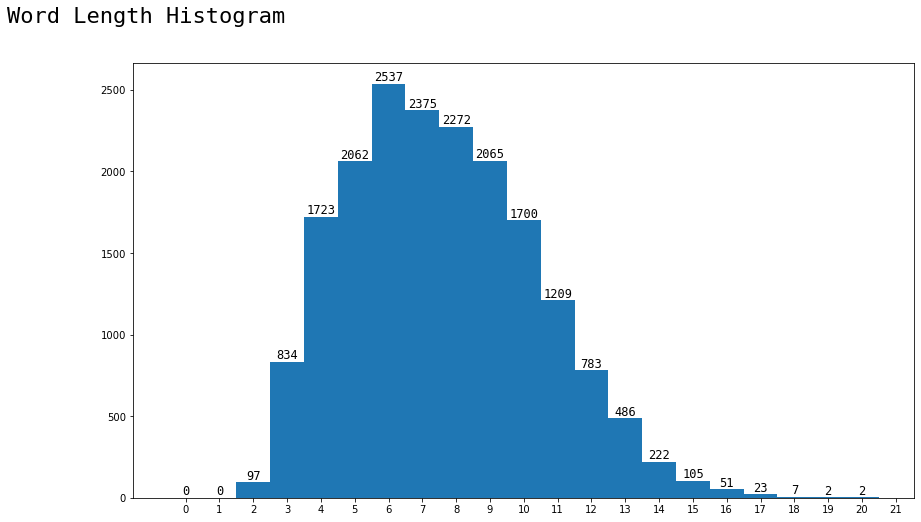

In [19]:
joined_text = ' '.join(df_train['process_step_3'])
words = list(set(re.split(" +", joined_text)))

word_lengths = []
for word in words:
    if (len(word)>0):
        word_lengths.append(len(word))

bins = np.arange(0, max(word_lengths) + 1.5) - 0.5
fig, ax = plt.subplots(figsize = (14,8))
_ = ax.hist(word_lengths, bins)
_ = ax.set_xticks(bins + 0.5)
ax.bar_label(ax.containers[0], fontname = 'monospace', fontsize = 12)

plt.figtext(0., .95, 'Word Length Histogram', fontname = 'monospace', size = 22, color = 'black')
plt.savefig('Word Length Histogram.png', bbox_inches='tight') 
plt.show()


### Sentence Length Histogram (Huda)

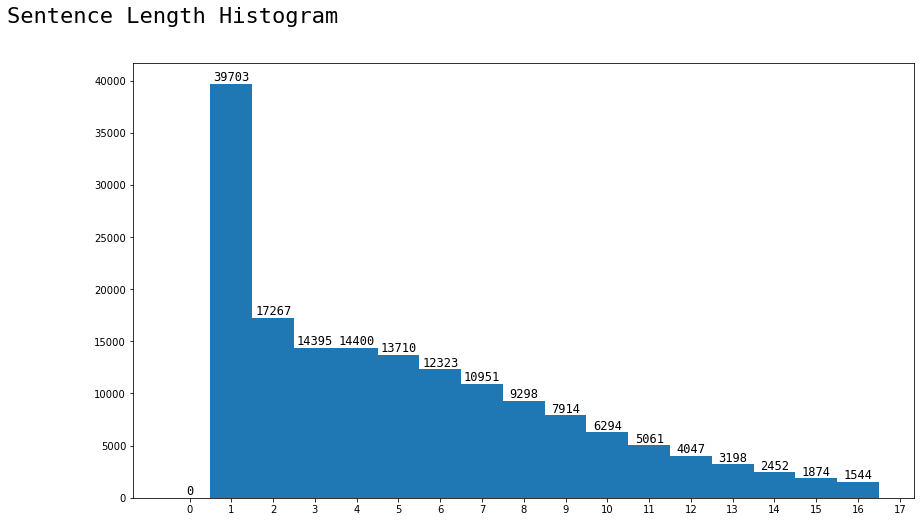

In [36]:
all_sent = []
for i, r in df_train.iterrows():  # Converting the data into seperate sentences
    all_sent += tokenize.sent_tokenize(r["process_step_2"])

sent_len = []

for s in all_sent: # Calculating the length of each sentence
    sent_len.append(len(word_tokenize(s)))

# remove outliers 
Q1 = np.quantile(sent_len, 0.25)
Q3 = np.quantile(sent_len, 0.75)
bound = 1.5*(Q3 - Q1) + Q3
sent_len = [val for val in sent_len if val < bound]

bins = np.arange(0, max(sent_len) + 1.5) - 0.5
fig, ax = plt.subplots(figsize = (14,8))
_ = ax.hist(sent_len, bins)
_ = ax.set_xticks(bins + 0.5)
ax.bar_label(ax.containers[0], fontname = 'monospace', fontsize = 12)

plt.figtext(0., .95, 'Sentence Length Histogram', fontname = 'monospace', size = 22, color = 'black')
plt.savefig('Sentence Length Histogram.png', bbox_inches='tight') 

### task c. Use both Matrix Factorization (LSA) and the LDA algorithms to do topic modelling. The output is a sequence of 10 words for each topic


### Tfidf features (XiaoChen)

In [21]:
v = TfidfVectorizer()

v.fit(df_train['process_step_3'])
train_tfidf = v.transform(df_train['process_step_3']).todense()
test_tfidf = v.transform(df_test['process_step_3']).todense()

vocab = v.get_feature_names_out()

print(train_tfidf.shape)

(11314, 18555)


### Latent Semantic Analysis (LSA) (XiaoChen)

In [22]:
svd_model = TruncatedSVD(n_components=20, random_state=2022)
svd_model.fit(train_tfidf)

TruncatedSVD(n_components=20, random_state=2022)

In [23]:
for i, comp in enumerate(svd_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key=lambda x: x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ", end = " ")
    for t in sorted_words:
        print(t[0], end=" ")
    print("\n")

Topic 0:  use one think like people make go time work see 

Topic 1:  file use drive card program disk please anyone monitor system 

Topic 2:  drive game team card play year win disk go season 

Topic 3:  game file team win play run program season year score 

Topic 4:  key chip use encryption clipper game phone government escrow system 

Topic 5:  file drive disk format win hard use key run program 

Topic 6:  card use video color monitor god run problem window driver 

Topic 7:  god card key game file please chip believe drive team 

Topic 8:  file card price sell new people sale government car offer 

Topic 9:  anyone think like go key chip look appreciate hi drive 

Topic 10:  god file car look good key bike one like buy 

Topic 11:  use gun game please file one people think monitor look 

Topic 12:  anyone need program appreciate good system work advance people government 

Topic 13:  please work go need use problem want game soon send 

Topic 14:  bank shameful chastity intellec

### Latent Dirichlet Allocation (LDA) (XiaoChen)

In [24]:
lda_model = LatentDirichletAllocation(n_components=20, random_state=2022)
lda_model.fit(train_tfidf)

LatentDirichletAllocation(n_components=20, random_state=2022)

In [25]:
for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key=lambda x: x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ", end=' ')
    for t in sorted_words:
        print(t[0], end=' ')
    print('\n')

Topic 0:  pit adobe chi la tor cal van mon phi ass 

Topic 1:  homosexual chop odometer conventional mule promiscuous rape prostitute arch omniscient 

Topic 2:  encryption key clipper escrow encrypt privacy cryptography chip secure crypt 

Topic 3:  holocaust republic motto cell empire slaughter creed cobra ruin humanist 

Topic 4:  lame zenith micron kindly convertible arcade plotter polarity transition irony 

Topic 5:  surrender intellect shameful skepticism chastity bank soon ultra stealth orchid 

Topic 6:  di ax pirate mi revolver mu um homicide trigger migraine 

Topic 7:  hall pitcher ivy corn blaster fame champ healthy statistic dither 

Topic 8:  excel trek distributor island quantity chuck speedometer executable medicine intrepid 

Topic 9:  window motif server client icon application manager greet symbol try 

Topic 10:  period scorer civic cat tonight chemistry nickname sh play sail 

Topic 11:  cam bitch dell slowly cornerstone rover domestic disgruntle gup lotus 

Topic

### d. Compare your topics between LSA and LDA and prepare yourself for questions about it (and other subjects) during your presentation.

### e. Use the labels provided in the dataset to measure the performance of both algorithms based on both accuracy and the F1 score

### LSA Performance (Xuehao)

In [26]:
svd_topics_train = svd_model.transform(train_tfidf)
svd_topics_train = svd_topics_train.argmax(axis=1)

In [27]:
# map svd topic to topic label
svd_to_topic_lable = {}

pair_counter = Counter(list(zip(svd_topics_train, df_train["topic"].to_numpy()))).most_common()

for pair, freq in pair_counter:
    k, v = pair
    k, v = int(k), int(v)
    if k in list(svd_to_topic_lable.keys()):
        continue
    svd_to_topic_lable[k] = v

svd_topics_train_prediction = list(map(lambda x:svd_to_topic_lable.get(x), svd_topics_train))

In [28]:
accuracy_score(df_train["topic"].to_numpy(), svd_topics_train_prediction)

0.12541983383418773

In [29]:
f1_score(df_train["topic"].to_numpy(), svd_topics_train_prediction, average='micro')

0.12541983383418773

### LDA Performance (Xuehao)

In [30]:
lda_topics_train = lda_model.transform(train_tfidf)
lda_topics_train = lda_topics_train.argmax(axis=1)

In [31]:
# map lda topic to topic label
lda_to_topic_lable = {}

pair_counter = Counter(list(zip(lda_topics_train, df_train["topic"].to_numpy()))).most_common()
for pair, freq in pair_counter:
    k, v = pair
    k = int(k)
    v = int(v)
    if k in list(lda_to_topic_lable.keys()):
        continue
    lda_to_topic_lable[k] = v

lda_topics_train_prediction = list(map(lda_to_topic_lable.get, lda_topics_train))

In [32]:
accuracy_score(df_train["topic"].to_numpy(), lda_topics_train_prediction)

0.08237581757115078

In [33]:
f1_score(df_train["topic"].to_numpy(), lda_topics_train_prediction, average='micro')

0.08237581757115078

### task f. LSA and LDA are unsupervised algorithms. In this part, try to apply logistic regression to this problem to see if you can predict the topic in a supervised fashion. Note that this problem no longer is a binary classification problem. You have to find a way to convert it to binary classification.

### Using SVD to reduce feature's dimension (Xuehao)

In [34]:
svd_model = TruncatedSVD(n_components=100)

svd_model.fit(train_tfidf)
svd_features_train = svd_model.transform(train_tfidf)
svd_features_test = svd_model.transform(test_tfidf)

print(svd_features_train.shape)

(11314, 100)


### Train LogisticRegression model and eval (Xuehao)

In [35]:
svd_clf = LogisticRegression(random_state=0, multi_class="ovr")

svd_clf.fit(svd_features_train, df_train["topic"].to_numpy())

svd_clf.score(svd_features_test, df_test["topic"].to_numpy())

0.5134094530005311